## Небольшое вступление(для лучшего понимания читателем изложенного материала


In [1]:
# 1) Выводы записаны не в тексовом файле, а в рабочем ноутбуке т.к.
# те вовыды, которые будут получены можно будет сразу же и проверить, а также
# появляется возможность иметь улучшенный прототип, который можно использовать

# UPDATE: т.к. из чата прилетела инфа, что ноутбуки категорически запрещены,
# решено перенести все выклдавки в pdf, но сам факт наличия воспроизводимого
# анализа  + сам ноутбук будут не лишними

# Ноут построен по аналогии как и данный нам, некоторые пункты идут не по порядку.
# Надеюь он будет читабелен p.s. я старался сделать это)

In [64]:
import os
import itertools
from itertools import chain
import random

In [3]:
import numpy as np
import scipy as sp

import pandas as pd
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (15, 10)
%matplotlib inline

In [4]:
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [5]:
import torch
import torch.nn as nn

In [107]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
SEED = 42

ROOT = ""

dataset_csv = "dataset.csv"

In [7]:
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything() # для воспроизводимости результатов

# Представленная работа с внесёнными изменениями и моими размышлениями

### Загружаем библиотеки

In [8]:
# Здесь без комментариев т.к. это просто импорт библиотек

### Загружаем данные

In [9]:
data_df = pd.read_csv(os.path.join(ROOT, dataset_csv), sep=";", index_col=0, header=0)
data_df

,Unnamed: 0.1,school,school_setting,school_type,classroom,teaching_method,n_student,gender,lunch,posttest,target
0,0,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify,72.0,1.0
1,1,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify,79.0,0.0
2,2,ANKYI,Urban,Non-public,6OL,Standard,NaN,Male,Does not qualify,76.0,1.0
3,3,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify,77.0,1.0
4,4,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify,76.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2128,2128,ZOWMK,Urban,Public,ZBH,Standard,30.0,Female,Does not qualify,55.0,NaN
2129,2129,ZOWMK,Urban,Public,ZBH,Standard,30.0,Female,Qualifies for reduced/free lunch,46.0,NaN
2130,2130,ZOWMK,Urban,Public,ZBH,Standard,30.0,Female,Qualifies for reduced/free lunch,51.0,NaN
2131,2131,ZOWMK,Urban,Public,ZBH,Standard,30.0,Male,Qualifies for reduced/free lunch,53.0,NaN


In [10]:
# Первый и явно пропущенный шаг(возможно это ошибка на этапе пересохранения
# файла и выставление на площадку для соревнования), это то, что возникают
# 2 первые колонки дубликатов(в изначальном варианте Model_students_upd.ipynb)

# Избавимся от этих столбцов(в моём случае от одного столбца т.к.
# 1-ый я занём в  индекс) т.к. очевидно он бесполезны(бесполезен)

df = data_df.copy()
df = df.drop(columns=["Unnamed: 0.1"])
print(df.shape)
df

(2133, 10)


,school,school_setting,school_type,classroom,teaching_method,n_student,gender,lunch,posttest,target
0,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify,72.0,1.0
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify,79.0,0.0
2,ANKYI,Urban,Non-public,6OL,Standard,NaN,Male,Does not qualify,76.0,1.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify,77.0,1.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,Male,Does not qualify,76.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2128,ZOWMK,Urban,Public,ZBH,Standard,30.0,Female,Does not qualify,55.0,NaN
2129,ZOWMK,Urban,Public,ZBH,Standard,30.0,Female,Qualifies for reduced/free lunch,46.0,NaN
2130,ZOWMK,Urban,Public,ZBH,Standard,30.0,Female,Qualifies for reduced/free lunch,51.0,NaN
2131,ZOWMK,Urban,Public,ZBH,Standard,30.0,Male,Qualifies for reduced/free lunch,53.0,NaN


### Заменим пропуски в данных

In [11]:
# заполняем "n_student" т.к. данная статистика необхожима для дальнейшего создания фичи, предложенной авторами

In [12]:
df["n_student"].fillna(df["n_student"].mean(), inplace=True)

### Заинжинирим новую переменную

In [15]:
# Чтобы посчитать статистику по всему df, производим инженеринг данных сначала, а потом
# уже делим df на train/test

In [24]:
# здесь без особого комментирование, т.к. создание новых фичей дело
# творческое

def create_woe_feature(df):
    for i in df.gender.unique():
        for j in df.n_student.unique():
            l=df.loc[(df.gender==i) & (df.n_student>=j)]
            woe=l.target.sum()/(l.target.count() - df.target.mean() - 1)
            df.loc[(df.gender==i) & (df.n_student>=j), 'woe_agegender']=woe

create_woe_feature(df)

In [25]:
df

,school,school_setting,school_type,classroom,teaching_method,n_student,gender,lunch,posttest,target,woe_agegender
0,ANKYI,Urban,Non-public,6OL,Standard,20.00000,Male,Does not qualify,72.0,1.0,0.503355
1,ANKYI,Urban,Non-public,6OL,Standard,20.00000,Male,Does not qualify,79.0,0.0,0.503355
2,ANKYI,Urban,Non-public,6OL,Standard,22.75339,Male,Does not qualify,76.0,1.0,0.508093
3,ANKYI,Urban,Non-public,6OL,Standard,20.00000,Male,Does not qualify,77.0,1.0,0.503355
4,ANKYI,Urban,Non-public,6OL,Standard,20.00000,Male,Does not qualify,76.0,0.0,0.503355
...,...,...,...,...,...,...,...,...,...,...,...
2128,ZOWMK,Urban,Public,ZBH,Standard,30.00000,Female,Does not qualify,55.0,NaN,0.542657
2129,ZOWMK,Urban,Public,ZBH,Standard,30.00000,Female,Qualifies for reduced/free lunch,46.0,NaN,0.542657
2130,ZOWMK,Urban,Public,ZBH,Standard,30.00000,Female,Qualifies for reduced/free lunch,51.0,NaN,0.542657
2131,ZOWMK,Urban,Public,ZBH,Standard,30.00000,Male,Qualifies for reduced/free lunch,53.0,NaN,0.606472


### Разобьем выборку на train / test

In [26]:
# Перед тем, как разбивать данные на train/test, я задамся вопросом, а что
# от модели хотят получить?

# Ответ: Задача построить модель прогнозирования факта сдачи теста.

# Т.е. по факту наша модель на основе данных(нагенерированных фичей)
# конкретного ученика должна выдать нам вероятность того, что данный ученик
# сдаст тест

# Т.е. если вероятность сдачи напрямую определяется через кол-во баллов,
# полученных учеником, то поиск конкретных баллов ученика должен нам помочь 

Text(0.5, 1.0, 'Распределение кол-ва сдавших/не сдавших в зависиости от баллов за тест')

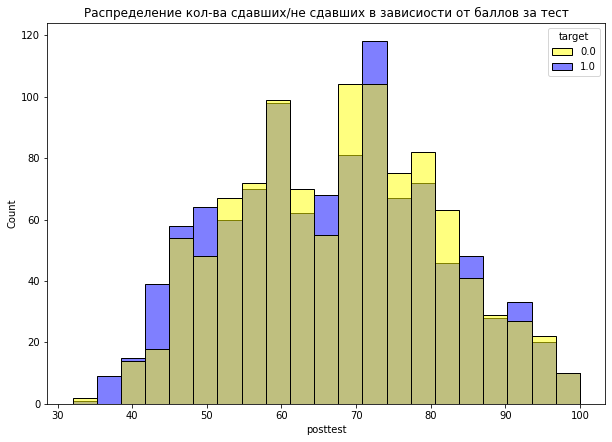

In [27]:
# Давайте проверим, а на сколько кол-во баллов влияют на сдачу теста

plt.figure(figsize=(10, 7))
sns.histplot(x="posttest", data=df, hue="target", palette=["yellow", "blue"]);
plt.title('Распределение кол-ва сдавших/не сдавших в зависиости от баллов за тест')

In [28]:
# Как можно заметить, распределения "практически" тождественны, что
# никак не помогает ответить на вопрос об удачности сдачи теста, а
# использование в качестве таргета колонку - "posttest"(баллы за тест), 
# является ошибкой на уровне понимания вопроса, поставленного перед
# нами

# ИСПРАВЛЕНИЯ:
# 1) Тарегет: - это сам факт сдачи/ не сдачи учеником теста - колонка "target"
# 2) В качестве лосса теперь используем лог-лосс(кросс энтропия)
# 3) Модель - логистическая регрессия(предположим, что
# раз используется именно лин.регрессия, то подразумевается использование
# класса линейных моделей)

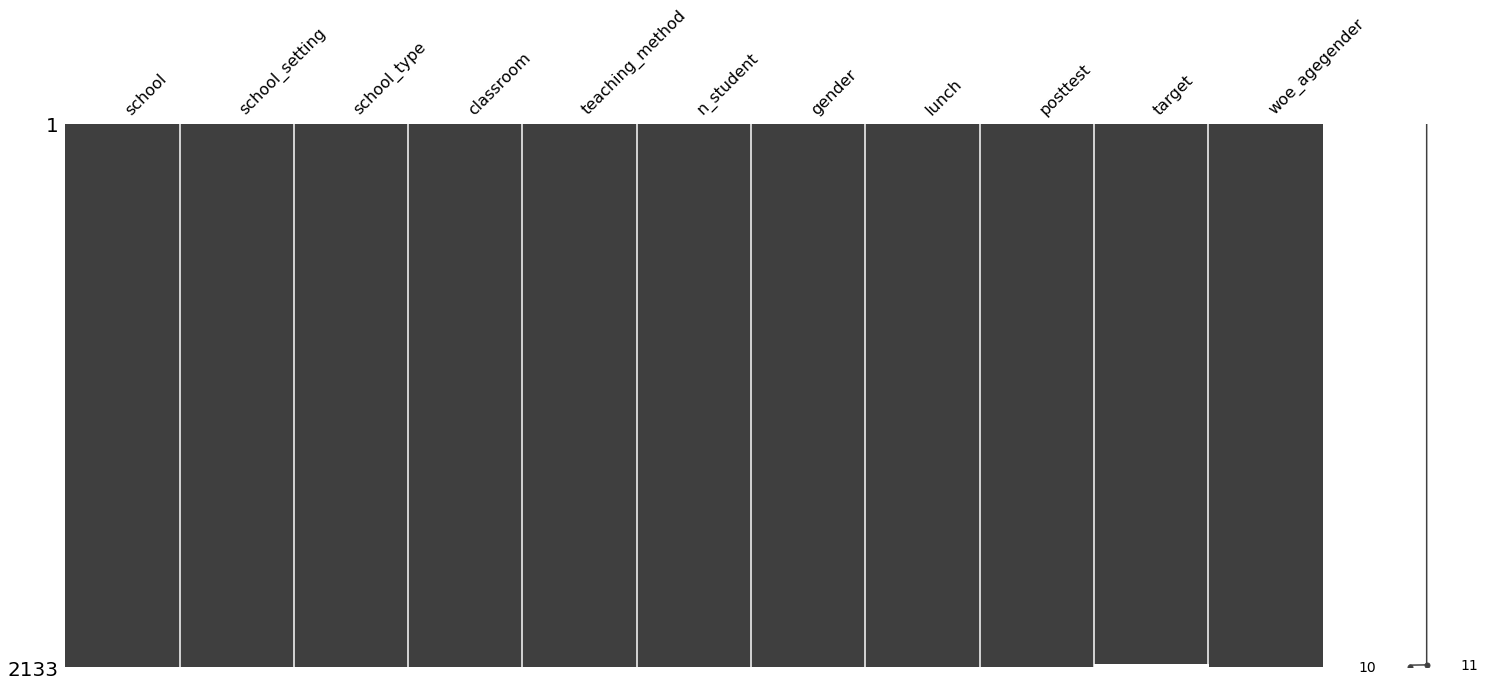

In [29]:
# Таким образом производим разбитие данных на train/test

# Но, перед этим убедимся, что столбец target не содержит NaN

msno.matrix(df);

In [30]:
# Как можно заметить, в самом конце имеются пропуски,
print("Процентное соотношение пропусков в target: ", df["target"].isna().sum() / len(df))

# От них можно просто избавиться
df = df[~df["target"].isna()]

Процентное соотношение пропусков в target:  0.0046882325363338025


In [31]:
# Таким образом производим разбитие данных на train/test, 
# но перед этим посмотрим, на соотношение класов target в df

df["target"].value_counts(normalize=True)

1.0    0.502591
0.0    0.497409
Name: target, dtype: float64

In [32]:
# Как видим, дисбаланса классов не наблюдается, но
# в отличие от авторского примера, разбиение будем делать
# стратифицированное по target

# Таким образом производим разбитие данных на train/test

X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape 

((1698, 10), (1698,), (425, 10), (425,))

In [33]:
# убедимся, что стратификация отработала
y_train.value_counts(normalize=True)

1.0    0.502356
0.0    0.497644
Name: target, dtype: float64

In [34]:
y_test.value_counts(normalize=True)

1.0    0.503529
0.0    0.496471
Name: target, dtype: float64

### Дальше накинем one-hot encoding( + StandartScaler)

In [38]:
df.columns.values

array(['school', 'school_setting', 'school_type', 'classroom',
       'teaching_method', 'n_student', 'gender', 'lunch', 'posttest',
       'target', 'woe_agegender'], dtype=object)

In [49]:
num_columns = ["n_student", "posttest", "woe_agegender"]
cat_columns = ["school", "school_setting", "school_type", "classroom", "teaching_method", "gender", "lunch"]
target = "target"

In [40]:
# В Model_students_upd.ipynb происходит не one-hot-encoding,
# а label encoding.

# Для применения label encoding нужно как минимум проверить, а являются
# ли данные порядковыми + было бы желательно обладать знаниями о 
# том, как можно смоделировать отношение порядка между разными соседними
# порядковыми единицами 

# Данной информацией мы не обладаем, к тому же кол-во столбцов
# позволяет нам провести one-hot-encoding

In [55]:
# кол-во категорий
X_train[cat_columns].nunique()

school             23
school_setting      3
school_type         2
classroom          97
teaching_method     2
gender              2
lunch               2
dtype: int64

In [42]:
# classroom скорее всего не является важной фичей(можно как минимум
# посмотретьт на распределение значенмя target по категориям classroom),
cat_columns.remove("classroom")
cat_columns

['school',
 'school_setting',
 'school_type',
 'teaching_method',
 'gender',
 'lunch']

In [43]:
from sklearn.preprocessing import OneHotEncoder

In [54]:
one_hot_encoder = OneHotEncoder(drop="if_binary", sparse=False)
one_hot_encoder.fit(X_train[cat_columns])

OneHotEncoder(drop='if_binary', sparse=False)

#### +StandartScaler

In [ ]:
# Не забываем, что линейные модели очень требовательны к препроцессингу
# данных, а также предполагют нрмальность рапределения неустранимой ошибки.

# Помимо этого, масштаб признаков, подаваемых в линейную модель должен
# сопоставим друг с другом, чего к изначальном ноутбуке не проделалось ....

# ИСПРАВЛЕНИЕ:
# 1) Нормализирием num_columns для подачи их в лейную модель

In [56]:
from sklearn.preprocessing import StandardScaler

In [59]:
standart_scaler = StandardScaler()
standart_scaler.fit(X_train[num_columns])

StandardScaler()

In [ ]:
# как можно заметить, действительно данные имеют 
# различный масштаб, что мы и утсраняем с помощью standart_scaler

In [63]:
standart_scaler.mean_, standart_scaler.scale_ 

(array([22.67851563, 67.13898704,  0.51008578]),
 array([ 3.99647496, 13.73545272,  0.02146912]))

In [ ]:
#

<font color="green" size=5>Дополнительная секция</font>

In [ ]:
# Аналогичной секции нет в Model_students_upd.ipynb

# Так как процесс обучения скомкан и не выделен в отдельную секцию, 
# процесс обучения модели и вариации улучшения способов обученя модели
# рассмотрит ниже

### Создадим train/test данные(предобработанные DataFrame), для удобства

In [98]:
def create_df_preprocess(X_df, one_hot_encoder=one_hot_encoder, standart_scaler=standart_scaler, num_columns=num_columns):
    X_df_ohe = one_hot_encoder.transform(X_df[cat_columns])
    X_df_ss = standart_scaler.transform(X_df[num_columns])
    
    X_df_preprocess = pd.DataFrame(data=np.concatenate([X_df_ohe, X_df_ss], axis=1),
                          columns=chain(one_hot_encoder.get_feature_names(), num_columns),
                          index=X_df.index)
    return X_df_preprocess

In [103]:
X_train_preprocess = create_df_preprocess(X_train)
X_test_preprocess = create_df_preprocess(X_test)

### Обучение логистической регрессии

In [ ]:
# Теперь, когда мы постарались учесть ошибки, которые были произведены
# в Model_students_upd.ipynb, время обучать модель

# Но, мы не будем проивзодить аналогичный процеcс обучения модели, а
# постараеся его улучшить
# 1) Даныые уже разделены test данные должны использоваться именно для
# тестирования конечно модели, после того, как она прошла валидацию, для
# чекпоинта своих ожиданий, что модель в итоге показывает +- похожее
# качетво на validation

# 2) Данные train - их не много + всегда есть шанс просто переобучиться на
# разбиение данных, поэтому будем обучать модель с помощью кроссвалидации

# 3) Также, почему бы и не использовать перебор по сетке параметров, чего
# также не было сделано в Model_students_upd.ipynb

# 4) Отсеивание признаков также за собой не несёт особо смысла т.к.
# выбрано слишком слабое условие на pvalue = 0.0  + не произовдился никакой 
# препроцессинг данных, что пагубно влияет на адекватность выводов
# 
# 5) Отсеивание признаков наиболее правильно произовить с регуляризацией \
# L1 т.к. именно в этом случае, модель чаще обнуляет менее валидные признаки


# Также примечание, что в случае задачи классификации нам очевидно
# нужна метрики и дисбаланса классов не наблюдается, то
# вполне естественным оказывается взять accuracy, хотя 
# в зависимоти уже от конкретных запросов можем использовать и другие метрики

In [106]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [115]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

In [130]:
# для визуализации
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [ ]:
# Для начала воспроизведём аналогичный подход и просто обучим
# нашу модель на X_train_preprocess

In [121]:
log_reg_v1 = LogisticRegression(random_state=SEED)
log_reg_v1.fit(X_train_preprocess, y_train)

LogisticRegression(random_state=42)

In [122]:
train_predicitons_v1 = log_reg_v1.predict(X_train_preprocess)
test_predicitons_v1 = log_reg_v1.predict(X_test_preprocess)

In [123]:
print("train accuracy:", accuracy_score(y_train, train_predicitons_v1))
print("train loss:", log_loss(y_train, train_predicitons_v1))

train accuracy: 0.6018845700824499
train loss: 13.750562497633082


In [124]:
print("test accuracy:", accuracy_score(y_test, test_predicitons_v1))
print("test loss:", log_loss(y_test, test_predicitons_v1))

test accuracy: 0.5011764705882353
test loss: 17.228944364850623


In [125]:
# различия не стольо существенны, но всё же модель очевидно лучше отрабатывает
# на тренировочных данных, возможно различие не столь большое из-за
# аккуратной стратифицированной выборке + препроцессинг

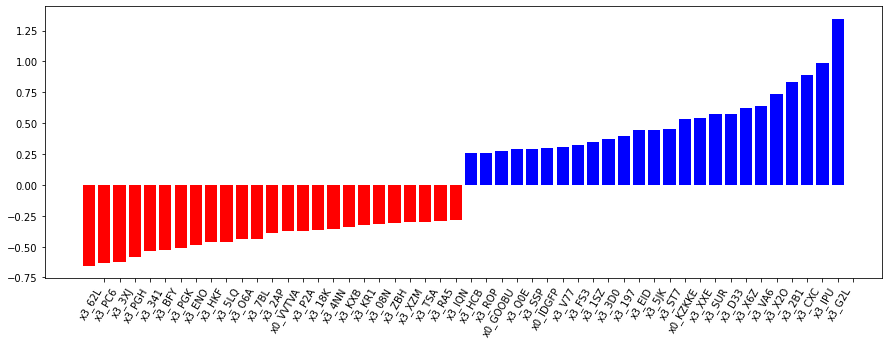

In [129]:
# как можно заметить, для логистической регрессии среди наиболее интересных пока даже не наблюдаем численных признаков,
# хотяя опять же судить судить лишь по проведённому процессу обучения не особо хочется
visualize_coefficients(log_reg_v1, X_train_preprocess.columns.values)

In [135]:
# Теперь проведём cv, как и планировали

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
c_values = np.logspace(-2, 3, 500)

In [136]:
log_reg_v2 = LogisticRegression()

In [137]:
log_reg_v2_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=2, n_jobs=-1)
log_reg_v2_searcher.fit(X_train_preprocess, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.0s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.4s finished


LogisticRegressionCV(Cs=array([1.00000000e-02, 1.02334021e-02, 1.04722519e-02, 1.07166765e-02,
       1.09668060e-02, 1.12227736e-02, 1.14847155e-02, 1.17527712e-02,
       1.20270833e-02, 1.23077980e-02, 1.25950646e-02, 1.28890361e-02,
       1.31898690e-02, 1.34977233e-02, 1.38127630e-02, 1.41351558e-02,
       1.44650734e-02, 1.48026913e-02, 1.51481892e-02, 1.55017512e-02,
       1.58635653e-02, 1.62...
       6.45088409e+02, 6.60144909e+02, 6.75552832e+02, 6.91320378e+02,
       7.07455942e+02, 7.23968114e+02, 7.40865683e+02, 7.58157646e+02,
       7.75853206e+02, 7.93961785e+02, 8.12493021e+02, 8.31456781e+02,
       8.50863158e+02, 8.70722485e+02, 8.91045332e+02, 9.11842520e+02,
       9.33125118e+02, 9.54904456e+02, 9.77192128e+02, 1.00000000e+03]),
                     cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                     n_jobs=-1, verbose=2)

In [139]:
# оптимальный коэф регуляризации
log_reg_v2_searcher.C_

array([250.49415422])

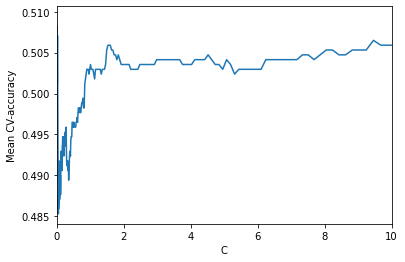

In [140]:
# как можно заметить, параметры по умолчанию для коэф регуляризации далеко
# не идеальны
plt.plot(c_values, np.mean(log_reg_v2_searcher.scores_[1], axis=0))
plt.xlabel('C')
plt.ylabel('Mean CV-accuracy');
plt.xlim((0,10));

In [142]:
train_predicitons_v2 = log_reg_v2_searcher.predict(X_train_preprocess)
test_predicitons_v2 = log_reg_v2_searcher.predict(X_test_preprocess)

In [143]:
print("train accuracy:", accuracy_score(y_train, train_predicitons_v2))
print("train loss:", log_loss(y_train, train_predicitons_v2))

train accuracy: 0.6042402826855123
train loss: 13.669198595879799


In [144]:
print("test accuracy:", accuracy_score(y_test, test_predicitons_v2))
print("test loss:", log_loss(y_test, test_predicitons_v2))

test accuracy: 0.508235294117647
test loss: 16.985139355951418


In [ ]:
# как можно заметить, качество не сильно меняется и есть предположение, что
# не смотря на более оптимальный подбор параметров, 
# обьекты 2х классов в пространстве признаков на данный момент не являются
# хорошо линейно разделимы

In [ ]:
# К сожалению , время близится к завершению и здесь я бы хотел досказать то,
# что точно имеет смысл попробовать.

# 1) Условжнение модели(другой класс моделей), если это конечно разрешено
# 2) Более серьёзный подход к генерации новых признаков т.к. очевидно, 
# сейчас классы не линейно разделимы при данных фичах

# 3) Использование для каждой модели поиска оптимальных параметров с банальным
# перебором + .predict_proba и поиск оптимального порога для улучшения качеста
# т.к. параметры по умолчанию могут быть не оптимальны

# 4) Испотльзование l2 регуляризации для отсечения неинформативных признаков + 
# по наиболее валидным уже строить снова модели